In [16]:
import pandas as pd
import numpy as np
import os

# local imports
import download_latest_covidtrackingdotcom_data as data_loader

# flag whether to save this output in the /data/interim/usa folder 
save_notebook_output = True

path_to_int_data = '../../../data/interim/usa'
fn_out = 'usa_states_covidtrackingdotcom_int_with_testing_regimes.csv'
fp_out = os.path.join(path_to_int_data, fn_out)

## define the functions to programmatically look for testing regime changes

In [17]:
def state_data_to_time_series(state_data):
    state_data_sorted = state_data.sort_values('date',inplace=False)
    
    timeseries_state_data = pd.Series(state_data_sorted['cumulative_tests'].values,
                    pd.DatetimeIndex([pd.to_datetime(x) for x in state_data_sorted['date'].values]))
    
    return state_data_sorted, timeseries_state_data

def calculate_testing_regimes(state_data, pct_chg_thresh=0.4, abs_chg_thresh=50):
    # calculates testing regimes as changing whenever the pct_chg of total tests between previous 
    # current dates is above pct_chg_thresh
        
    state_data_sorted, timeseries_state_data = state_data_to_time_series(state_data)
    
    pct_changes_in_testing = timeseries_state_data.pct_change(freq='D').values
    abs_changes_in_testing = timeseries_state_data.diff()

    testing_regimes = np.zeros(len(pct_changes_in_testing))
    regime = 0
    
    # transition to a new regime if the absolute *and* percent changes exceed the thresholds
    for i, (pct_change, abs_change) in enumerate(zip(pct_changes_in_testing, abs_changes_in_testing)):
        if pct_change > pct_chg_thresh and abs_change > abs_chg_thresh:
            regime += 1
        testing_regimes[i] = regime
        
    # return the pandas indices and the 
    return testing_regimes, state_data_sorted.index

# 1. Download the data locally 

In [18]:
# option a: take from local (avoids downloading again):
# data_loader.main() # to refresh data
states_data = pd.read_csv(os.path.join(fp_out.replace('_with_testing_regimes', '')))

# option b: download from covidtracker.com:
# don't save locally (you can, but you can also run the python script to refresh the underlying data)
#states_data_raw = data_loader.download_and_save_data_raw(save_locally=False)
#states_data = data_loader.process_and_save_data_int(states_data_raw, save_locally=False)

## 2. Programmatically add in testing regime changes

In [19]:
# 2. add variable for testing regime
states_data['testing_regime'] = 1

state_names = np.unique(states_data['adm1_name'])
print(len(state_names), "states represented")

# These factors determine what is programatically considered as a testing regime change candidate
pct_change_thresh = 2.5
abs_change_thresh = 150

for state in state_names:
    # find the testing regimes for this state
    state_data = states_data[states_data['adm1_name'] == state]
    state_testing_regimes, state_data_idxs =  calculate_testing_regimes(state_data, 
                                                                        pct_chg_thresh=pct_change_thresh,
                                                                        abs_chg_thresh=abs_change_thresh)

    states_data.loc[state_data_idxs,'testing_regime'] = state_testing_regimes
    

56 states represented


## 3. Manually inspect results
### 3a. print any date/state comboes with testing_regime > 0

In [20]:
# check on any places where we made a testing regime change -- we might want to manually change 
# anything that looks inconsistent
entries_with_regime_change = states_data[states_data['testing_regime'] >0].sort_values(['adm1_name','date'],inplace=False)
states_with_regime_change = np.unique(entries_with_regime_change['adm1_name'])

entries_with_regime_change

,date,adm0_name,adm1_name,adm_level,cumulative_confirmed_cases,cumulative_tests,cumulative_deaths,testing_regime
172,2020-03-16,USA,CA,1,335,8316.0,6.0,1.0
116,2020-03-17,USA,CA,1,483,8464.0,11.0,1.0
60,2020-03-18,USA,CA,1,611,8592.0,13.0,1.0
5,2020-03-19,USA,CA,1,924,9711.0,18.0,1.0
7,2020-03-19,USA,CT,1,96,700.0,1.0,1.0
189,2020-03-16,USA,ME,1,17,781.0,NaN,1.0
133,2020-03-17,USA,ME,1,32,1335.0,NaN,1.0
77,2020-03-18,USA,ME,1,43,1713.0,NaN,1.0
23,2020-03-19,USA,ME,1,53,2057.0,NaN,1.0
24,2020-03-19,USA,MI,1,336,2449.0,3.0,1.0


### 3b plot the states that have regime changes, + the states that 

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'date')

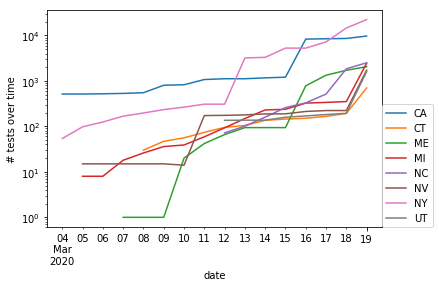

In [21]:
%pylab inline
import matplotlib.pyplot as plt

# note: we plot these b/c missing we don't want to miss a testing regime change in these states 
high_instances_states = []#['WA',"CA","NY",'FL',"MA"]

states_to_plot = np.union1d(high_instances_states,states_with_regime_change)
for state in states_to_plot:
#for state in state_names:

    state_data = states_data[states_data['adm1_name'] == state]

    _, ts = state_data_to_time_series(state_data)


    ts.plot(label=state)
    
    plt.legend(loc=(1,0))
    
    plt.yscale('log')
    
plt.ylabel('# tests over time')
plt.xlabel('date')

### 3c.  spot check and make any nessecary changes

Populating the interactive namespace from numpy and matplotlib
2020-03-07      5.0
2020-03-08      5.0
2020-03-09      5.0
2020-03-10     11.0
2020-03-11     18.0
2020-03-12     35.0
2020-03-13     82.0
2020-03-14    191.0
2020-03-15    336.0
2020-03-16    504.0
2020-03-17    562.0
2020-03-18    562.0
2020-03-19    562.0
dtype: float64


Text(0.5, 0, 'date')

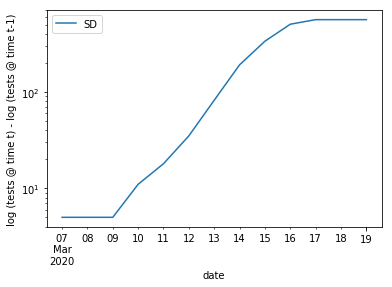

In [22]:
# make any refinements before changing

%pylab inline
import matplotlib.pyplot as plt

for state in ['SD']:
#for state in state_names:

    state_data = states_data[states_data['adm1_name'] == state]

    _, ts = state_data_to_time_series(state_data)
    print(ts)

    ts.plot(label=state)
    
    plt.legend()
    
    plt.yscale('log')
    
plt.ylabel('log (tests @ time t) - log (tests @ time t-1)')
plt.xlabel('date')

## 4. Make any changes to the testing regime designations

In [23]:
# for now i have none, but this will likeley change as ore data comes in

# the MS and MA changes don't look sever enough
for state in ['CT','NC']:
    states_data.loc[states_data['adm1_name'] == state, 'testing_regime'] = 0

In [24]:
# check the changes

entries_with_regime_change = states_data[states_data['testing_regime'] >0].sort_values(['adm1_name','date'],inplace=False)
states_with_regime_change = np.unique(entries_with_regime_change['adm1_name'])

entries_with_regime_change.sort_values(['adm1_name','date'])

,date,adm0_name,adm1_name,adm_level,cumulative_confirmed_cases,cumulative_tests,cumulative_deaths,testing_regime
172,2020-03-16,USA,CA,1,335,8316.0,6.0,1.0
116,2020-03-17,USA,CA,1,483,8464.0,11.0,1.0
60,2020-03-18,USA,CA,1,611,8592.0,13.0,1.0
5,2020-03-19,USA,CA,1,924,9711.0,18.0,1.0
189,2020-03-16,USA,ME,1,17,781.0,NaN,1.0
133,2020-03-17,USA,ME,1,32,1335.0,NaN,1.0
77,2020-03-18,USA,ME,1,43,1713.0,NaN,1.0
23,2020-03-19,USA,ME,1,53,2057.0,NaN,1.0
24,2020-03-19,USA,MI,1,336,2449.0,3.0,1.0
461,2020-03-11,USA,NV,1,5,173.0,NaN,1.0


Text(0.5, 0, 'date')

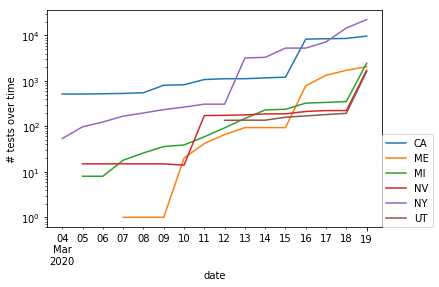

In [25]:
states_to_plot = states_with_regime_change
for state in states_to_plot:
#for state in state_names:

    state_data = states_data[states_data['adm1_name'] == state]

    _, ts = state_data_to_time_series(state_data)


    ts.plot(label=state)
    
    plt.legend(loc=(1,0))
    
    plt.yscale('log')
    
plt.ylabel('# tests over time')
plt.xlabel('date')

## 5. Save data!

In [30]:
if save_notebook_output:
    print('writing csv with testing regime changes to {0}'.format(fp_out))
    states_data.to_csv(fp_out, index=False)

writing csv with testing regime changes to ../../../data/interim/usa/usa_states_covidtrackingdotcom_int_with_testing_regimes.csv


# 6. extras

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'date')

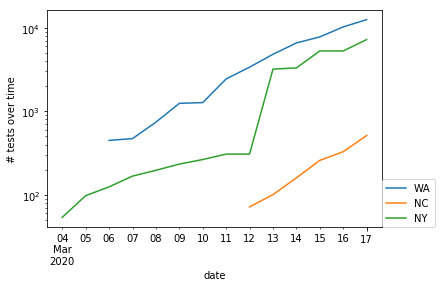

In [11]:
%pylab inline
import matplotlib.pyplot as plt

# note: we plot states_to_plot b/c missing we don't want to miss a testing regime change in these states 

states_to_plot = ['WA',"NC","NY"]
for state in states_to_plot:
#for state in state_names:

    state_data = states_data[states_data['adm1_name'] == state]

    _, ts = state_data_to_time_series(state_data)


    ts.plot(label=state)
    
    plt.legend(loc=(1,0))
    
    plt.yscale('log')
    
plt.ylabel('# tests over time')
plt.xlabel('date')